## Basic operations with Atmospheric data on native grid

In [1]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/eunbyeol/MPI/scheduler.json')  
client

<Client: 'tcp://203.247.189.224:41344' processes=7 threads=126, memory=586.73 GiB>

In [2]:
import xarray as xr
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [3]:
model = 'awicm3'
expid = 'TCo1279-DART' 
version = '2080C'
realm = 'oifs'
base = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"


In [4]:
# -------------------
# 1) YEAR RANGE FUNCTION (FIXED)
# -------------------
def extract_year_range(fname):
    m = re.search(r'_(\d{6})-(\d{6})\.nc$', fname)
    if m:
        y1 = int(m.group(1)[0:4])
        y2 = int(m.group(2)[0:4])
        return y1, y2
    return None, None   # <-- 여기로 이동됨

In [5]:
# -------------------
# 2) Get file list
# -------------------
files = os.listdir(base)

# -------------------
# 3) Target variable
# -------------------
target = "1d_2t"
var_key = target.split("_", 1)[1]   # "2t"

In [9]:
# -------------------
# 4) Select files by year
# -------------------
f_start_year = 2080
f_end_year = 2089

ds_files = sorted([f for f in files if target in f])

selected_files = []

for f in ds_files:
    y1, y2 = extract_year_range(f)
    if y1 is None:
        continue
    if (y2 >= f_start_year) and (y1 <= f_end_year):
        selected_files.append(os.path.join(base, f))

# print("Selected files:", selected_files)

In [10]:
 selected_files

['/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208001-208001.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208002-208002.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208003-208003.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208004-208004.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208005-208005.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208006-208006.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208007-208007.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208008-208008.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208009-208009.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208010-208010.nc',
 '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208011-208011.nc',
 '/scratch

In [11]:
# -------------------
# 5) Open dataset (FIXED)
# -------------------
ds = xr.open_mfdataset(
    selected_files,
    combine='by_coords',
    parallel=True,
    chunks={"time": 50},
)

print(ds)

<xarray.Dataset> Size: 868GB
Dimensions:               (time_counter: 3653, cell: 6599680, nvertex: 4,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] 29kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 29kB 2080-01-01T12:00...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lon            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    bounds_lat            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 58kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_coun

In [12]:
# -------------------
# 6) Variable load
# -------------------
if var_key not in ds:
    raise KeyError(f"Variable {var_key} not found. Available: {list(ds.data_vars.keys())}")

da = ds[var_key]

# -------------------
# 7) Select by time
# -------------------
time_dim = "time_counter" if "time_counter" in da.dims else "time"

da_sel = da.sel({time_dim: slice(f"{f_start_year}-01-01", f"{f_end_year}-12-31")})


In [13]:
# -------------------
# 8) Mean
# -------------------
with ProgressBar():
    da_mean = da_sel.mean(dim=time_dim).compute()

print(da_mean)

<xarray.DataArray '2t' (cell: 6599680)> Size: 26MB
array([267.03555, 267.0425 , 267.0473 , ..., 232.41449, 232.48389,
       232.53781], dtype=float32)
Coordinates:
    lat      (cell) float32 26MB 89.95 89.95 89.95 ... -89.95 -89.95 -89.95
    lon      (cell) float32 26MB 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
Dimensions without coordinates: cell


AttributeError: PathCollection.set() got an unexpected keyword argument 'extend'

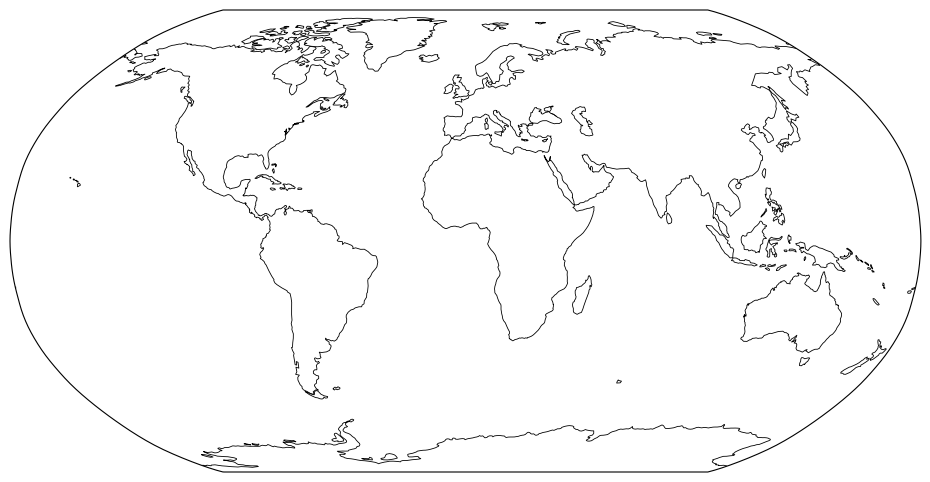

2025-11-27 14:45:06,029 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [14]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs

sstep = 10  
lon = ds["lon"].compute()
lat = ds["lat"].compute()

lon_s = lon[::sstep]
lat_s = lat[::sstep]
val_s = da_mean.values[::sstep]-273

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(linewidth=0.6,color='black')

sc = ax.scatter(
    lon_s, lat_s,
    c=val_s,
    s=1,
    transform=ccrs.PlateCarree(),
    vmin=-30,
    vmax=30,
    extend='both'
    
)

plt.title("2m Temperature", fontsize=14)
plt.colorbar(sc, orientation="horizontal",pad=0.01,shrink=0.7,label="Temperature (°C)", aspect=30)
plt.show()


In [4]:
import xarray as xr
import numpy as np
import os
import re


In [5]:
model = 'awicm3'
expid = 'TCo1279-DART' 
version = '2080C' # '1950C', '2080C'
realm = 'oifs'


In [7]:
def extract_year_range(fname): 
    m = re.search(r'_(\d{6})-(\d{6})\.nc$', fname) 
    if m: 
        y1 = int(m.group(1)[0:4]) 
        y2 = int(m.group(2)[0:4]) 
        return y1, y2 
        return None, None

In [6]:
base = f"/scratch/{model}/{expid}-{version}/outdata/{realm}/"

files = os.listdir(base)

pattern = r"atm_reduced_(.+?)_(.+?)_\1_.*\.nc"

# list of variables
vars_list = []

for f in files:
    m = re.match(r"atm_reduced_(.+?)_(.+?)_\1_.*\.nc", f)
    if m:
        tint, var = m.groups()
        vars_list.append(f"{tint}_{var}")

vars_list = sorted(set(vars_list))

print(vars_list)


['1d_10u', '1d_10v', '1d_2t', '1d_msl', '1d_ssr', '1d_str', '1d_tcc', '1d_tsr', '1d_tsrc', '1d_ttr', '1m_pl_cc', '1m_pl_clwc', '1m_swvl2', '3h_10u', '3h_10v', '3h_2t', '3h_cp', '3h_ewss', '3h_hcc', '3h_lcc', '3h_lsp', '3h_mcc', '3h_msl', '3h_nsss', '3h_pl_cc', '3h_pl_ciwc', '3h_pl_clwc', '3h_pl_q', '3h_pl_r', '3h_pl_t', '3h_pl_u', '3h_pl_v', '3h_pl_vo', '3h_pl_w', '3h_pl_z', '3h_tcc', '3h_tsr', '3h_tsrc']


In [15]:
# set: year range 

f_start_year = 2080 
f_end_year = 2089

In [16]:
# target variable

target = "1d_2t"
var_key = target.split("_", 1)[1]

# select files
ds_files = sorted([f for f in files if target in f])
selected_files = []
for f in ds_files:
    y1, y2 = extract_year_range(f)
    if y1 is None:
        continue
    if (y2 >= f_start_year) and (y1 <= f_end_year):
        selected_files.append(os.path.join(base, f))

print("Selected files:", selected_files)



Selected files: ['/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208001-208001.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208002-208002.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208003-208003.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208004-208004.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208005-208005.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208006-208006.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208007-208007.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208008-208008.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208009-208009.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208010-208010.nc', '/scratch/awicm3/TCo1279-DART-2080C/outdata/oifs/atm_reduced_1d_2t_1d_208011-208011.nc', '/sc

In [17]:
# import xarray as xr
import warnings
warnings.filterwarnings("ignore")

# open dataset
# ds = xr.open_mfdataset(selected_files, combine='by_coords')

ds = xr.open_mfdataset(
    selected_files,
    combine='by_coords',       # 좌표(time, lat, lon)가 일치하면 자동 병합
    parallel=True,             # 여러 파일을 병렬로 처리
    chunks={"time": 50},       # 원하는 chunk 크기 지정
)

print(ds)


# # search variable using var_key
# var_candidates = [v for v in ds.data_vars if var_key.lower() in v.lower()]
# if len(var_candidates) == 0:
#     raise ValueError(f"There is no '{var_key}' in dataset.")
# varname = var_candidates[0]
# print("Using variable:", varname)

# # check time dimension
# print("Dimensions:", ds[varname].dims)

<xarray.Dataset> Size: 868GB
Dimensions:               (time_counter: 3653, cell: 6599680, nvertex: 4,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] 29kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 29kB 2080-01-01T12:00...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lon            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    bounds_lat            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 58kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_coun

In [21]:
# 2) 원하는 변수 선택
var_key = target.split("_", 1)[1]   # 예: '2t'
da = ds[var_key]

print(da)

<xarray.DataArray '2t' (time_counter: 3653, cell: 6599680)> Size: 96GB
dask.array<concatenate, shape=(3653, 6599680), dtype=float32, chunksize=(1, 6599680), chunktype=numpy.ndarray>
Coordinates:
    lat            (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon            (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    time_centered  (time_counter) datetime64[ns] 29kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter   (time_counter) datetime64[ns] 29kB 2080-01-01T12:00:00 ......
Dimensions without coordinates: cell
Attributes:
    standard_name:       surface_air_temperature
    long_name:           2 metre temperature
    units:               K
    online_operation:    average
    interval_operation:  3 h
    interval_write:      1 d
    cell_methods:        time: mean (interval: 3 h)


In [31]:
# 3) 연도 범위로 자르기 (필요할 경우)

time_dim = "time_counter" if "time_counter" in da.dims else "time"
da_sel = da.sel({time_dim: slice(f"{f_start_year}-01-01", f"{f_end_year}-12-31")})

# da_sel = da.sel(time=slice(f"{f_start_year}-01-01", f"{f_end_year}-12-31"))

In [32]:


# 4) 평균 계산 예시
with ProgressBar():
    da_mean = da_sel.mean(dim="time_counter").compute()

print(da_mean)

<xarray.DataArray '2t' (cell: 6599680)> Size: 26MB
array([267.03555, 267.0425 , 267.0473 , ..., 232.41449, 232.48389,
       232.53781], dtype=float32)
Coordinates:
    lat      (cell) float32 26MB 89.95 89.95 89.95 ... -89.95 -89.95 -89.95
    lon      (cell) float32 26MB 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
Dimensions without coordinates: cell


In [34]:
print(ds)

<xarray.Dataset> Size: 868GB
Dimensions:               (time_counter: 3653, cell: 6599680, nvertex: 4,
                           axis_nbounds: 2)
Coordinates:
    lat                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon                   (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    time_centered         (time_counter) datetime64[ns] 29kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 29kB 2080-01-01T12:00...
Dimensions without coordinates: cell, nvertex, axis_nbounds
Data variables:
    bounds_lon            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    bounds_lat            (time_counter, cell, nvertex) float32 386GB dask.array<chunksize=(31, 6599680, 4), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] 58kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_coun

In [39]:
lon = ds.lon.load()
lat = ds.lat.load()

In [40]:
lon

<xarray.DataArray 'lon' (cell: 6599680)> Size: 26MB
array([  0.,  18.,  36., ..., 306., 324., 342.], dtype=float32)
Coordinates:
    lat      (cell) float32 26MB 89.95 89.95 89.95 ... -89.95 -89.95 -89.95
    lon      (cell) float32 26MB 0.0 18.0 36.0 54.0 ... 288.0 306.0 324.0 342.0
Dimensions without coordinates: cell
Attributes:
    standard_name:  longitude
    long_name:      Longitude
    units:          degrees_east
    bounds:         bounds_lon

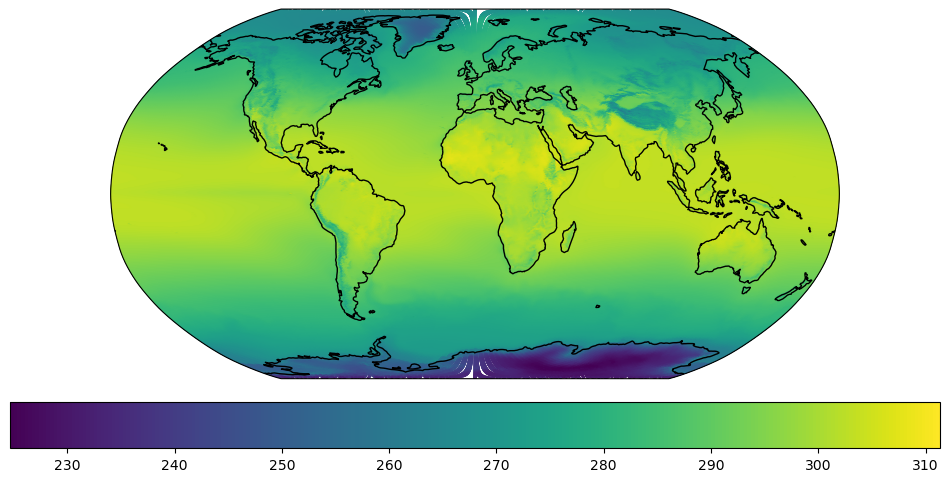

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

sstep = 10  # 10개마다 하나
lon_s = lon[::sstep]
lat_s = lat[::sstep]
val_s = da_mean.values[::sstep]

plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines()

sc = ax.scatter(
    lon_s, lat_s,
    c=val_s,
    s=1,
    transform=ccrs.PlateCarree(),
)

plt.colorbar(sc, orientation="horizontal", pad=0.05)
plt.show()


In [41]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

sstep = 10
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=da_mean.values[::sstep])
plt.colorbar()

NameError: name 'ds_mean' is not defined

## time average

In [18]:
# time average
time_dim = 'time_counter' if 'time_counter' in ds[varname].dims else 'time'
ds_mean = ds[varname].mean(dim=time_dim)
print(ds_mean)



<xarray.DataArray '2t' (cell: 6599680)> Size: 26MB
dask.array<mean_agg-aggregate, shape=(6599680,), dtype=float32, chunksize=(6599680,), chunktype=numpy.ndarray>
Coordinates:
    lat      (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
Dimensions without coordinates: cell


In [19]:
# import matplotlib.pyplot as plt
# import cartopy.crs as ccrs


# # ds_mean: (lat, lon) 
# data = ds_mean.values  

# plt.figure(figsize=(12,6))
# ax = plt.axes(projection=ccrs.Robinson())


# ax.coastlines(resolution='110m')
# ax.set_global()

# # scatter plot

# sc = ax.scatter(lon, lat, c=data, s=10, cmap='RdBu_r', transform=ccrs.PlateCarree())


# plt.colorbar(sc, orientation='horizontal', pad=0.05, label=varname)

# plt.title(f"Time-averaged {varname}")
# plt.show()


In [33]:
lon = ds.lon.values
lat = ds.lat.values

In [21]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
sstep = 10
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds_mean.values[::sstep])
plt.colorbar()

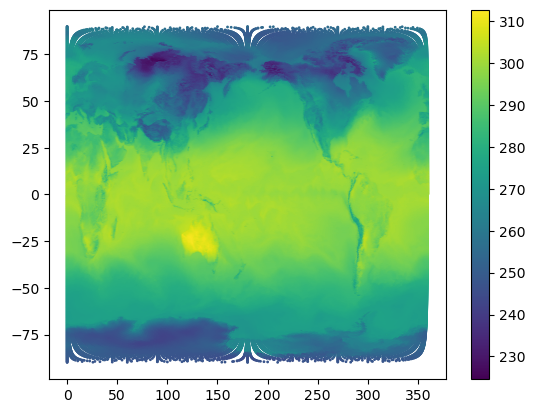

In [16]:
# sstep = 10
# plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds[var_key][0,::sstep])
# plt.colorbar()

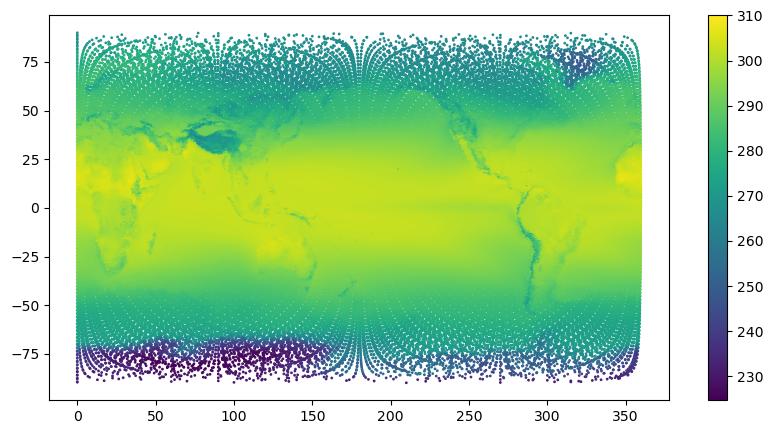

In [17]:
sstep = 50
plt.figure(figsize=(10,5))
plt.scatter(lon[::sstep], lat[::sstep], s=1, c=ds_mean.values[::sstep])
plt.colorbar()


## Cut region

In [18]:
left = 120
right = 140
bottom = 30
top = 45

In [19]:
region = (lon < right) & (lon>left) & (lat > bottom) & (lat < top)


In [30]:
ds_mean

<xarray.DataArray '2t' (cell: 6599680)> Size: 26MB
dask.array<mean_agg-aggregate, shape=(6599680,), dtype=float32, chunksize=(6599680,), chunktype=numpy.ndarray>
Coordinates:
    lat      (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
    lon      (cell) float32 26MB dask.array<chunksize=(6599680,), meta=np.ndarray>
Dimensions without coordinates: cell

In [29]:
# data_sample = ds[var_key][0,:].values
data_sample = ds_mean[var_key].values

KeyError: '2t'

In [ ]:
data_sample[region]

In [21]:

plt.figure(figsize=(20,10))
plt.scatter(lon[region], lat[region], s=30 , c=data_sample[region])
plt.colorbar(orientation='horizontal', pad=0.04)

NameError: name 'data_sample' is not defined

<Figure size 2000x1000 with 0 Axes>

## Simple map with projection

In [22]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import cm

NameError: name 'data_sample' is not defined

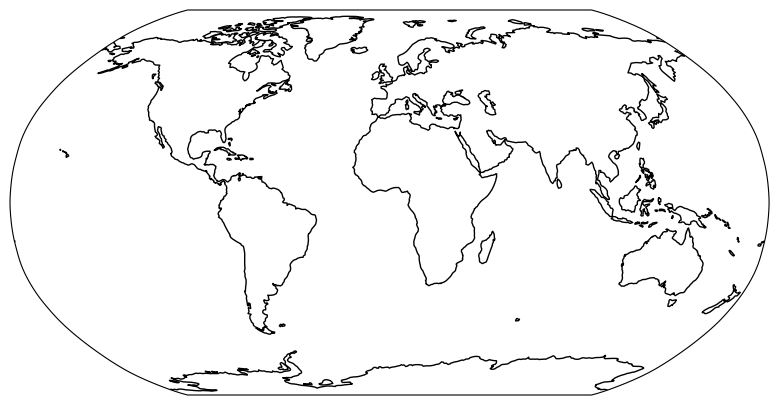

In [23]:
sstep = 50
plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')
ax.scatter(lon[::sstep], lat[::sstep], s=1 , c=data_sample[::sstep],
            cmap=cm.RdBu_r, transform=ccrs.PlateCarree())

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
mm = ax.scatter(lon[region], lat[region], s=5 , c=data_sample[region]-273, 
           vmin=-20, vmax=20,
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
plt.colorbar(mm, orientation='horizontal', pad=0.04)

## Simple interpolation to a regular grid

In [ ]:
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator

In [ ]:
lon_geo = np.linspace(120, 140, 160)
lat_geo = np.linspace(30, 45, 160)
lon_geo2, lat_geo2 = np.meshgrid(lon_geo, lat_geo)

In [ ]:
points = np.vstack((lon, lat)).T

In [ ]:
%%time
nn_interpolation = NearestNDInterpolator(points, data_sample)

In [ ]:
interpolated_nn = nn_interpolation((lon_geo2, lat_geo2))

In [ ]:
plt.imshow(interpolated_nn)

In [ ]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines(resolution='10m', color='k')
# ax.set_extent([left, right, bottom, top], crs=ccrs.PlateCarree())
#ax.stock_img()
img = ax.contourf(lon_geo, lat_geo, interpolated_nn-273, 
           levels = np.linspace(-30,30,31),
           cmap=cm.RdBu_r, transform=ccrs.PlateCarree())
# ax.contour(lon_geo, lat_geo, interpolated_nn-273, 
#            levels = np.linspace(-30,30,31),
#            transform=ccrs.PlateCarree(), colors='k', linewidths=0.5)
#ax.add_feature(
#            cfeature.GSHHSFeature(levels=[1], scale="low", facecolor="lightgray")
#        )
#ax.stock_img()
# ax.add_feature(cfeature.OCEAN, zorder=10, edgecolor='black')
cbar = plt.colorbar(img, orientation='horizontal', pad=0.03)
cbar.set_label('$^\circ$C')